In [1]:
"""
=============================================================================
UYGULAMA 2: Gelişmiş Veri Ön İşleme Pipeline'ı
=============================================================================
Kapsam:
  - Custom Transformer (OutlierClipper, FrequencyEncoder)
  - IterativeImputer (MICE algoritması)
  - Pipeline + ColumnTransformer
  - Data Leakage'ı kaçınma rehberi
  - FunctionTransformer ile log dönüşüm
  - Pipeline parametrelerine get_params() erişimi

Veri: UCI Bank Marketing (direkt yüklenir)
Gereksinimler: pip install scikit-learn pandas numpy matplotlib seaborn
=============================================================================
"""

"\n=============================================================================\nUYGULAMA 2: Gelişmiş Veri Ön İşleme Pipeline'ı\n=============================================================================\nKapsam:\n  - Custom Transformer (OutlierClipper, FrequencyEncoder)\n  - IterativeImputer (MICE algoritması)\n  - Pipeline + ColumnTransformer\n  - Data Leakage'ı kaçınma rehberi\n  - FunctionTransformer ile log dönüşüm\n  - Pipeline parametrelerine get_params() erişimi\n\nVeri: UCI Bank Marketing (direkt yüklenir)\nGereksinimler: pip install scikit-learn pandas numpy matplotlib seaborn\n=============================================================================\n"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, RobustScaler, OneHotEncoder,
    OrdinalEncoder, FunctionTransformer, LabelEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")


In [4]:
# ─────────────────────────────────────────────────────────────
# 1. VERİ YÜKLEME & YAPAY EKSİK DEĞER EKLEME
# ─────────────────────────────────────────────────────────────
print("=" * 65)
print(" UYGULAMA 1: Gelişmiş Veri Ön İşleme Pipeline'ı")
print("=" * 65)

# UCI Bank Marketing veri setini yükle
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional-full.csv"
try:
    df = pd.read_csv(url, sep=";")
    print(f"\n✅ Veri indirildi: {df.shape[0]:,} satır, {df.shape[1]} sütun")
except Exception:
    # Veri indirilemezse örnek veri oluştur
    print("\n⚠️ İnternet erişimi yok, örnek veri oluşturuluyor...")
    np.random.seed(42)
    n = 5000
    df = pd.DataFrame({
        "age": np.random.randint(18, 75, n).astype(float),
        "job": np.random.choice(["admin.", "blue-collar", "technician",
                                 "services", "management", "retired"], n),
        "marital": np.random.choice(["married", "single", "divorced"], n),
        "education": np.random.choice(["basic.4y", "high.school",
                                       "university.degree", "professional.course"], n),
        "balance": np.random.normal(1500, 3000, n),
        "duration": np.abs(np.random.normal(260, 260, n)),
        "campaign": np.random.randint(1, 10, n).astype(float),
        "pdays": np.random.choice([999] + list(range(0, 30)), n, p=[0.85]+[0.005]*30).astype(float),
        "previous": np.random.randint(0, 5, n).astype(float),
        "contact": np.random.choice(["telephone", "cellular"], n),
        "poutcome": np.random.choice(["failure", "success", "nonexistent"], n),
        "y": np.random.choice(["yes", "no"], n, p=[0.12, 0.88]),
    })

# Target oluştur
df["target"] = (df["y"] == "yes").astype(int)

# Yapay eksik değer ekle (gerçekçi senaryo)
np.random.seed(42)
for col in ["age", "balance", "duration"]:
    mask = np.random.rand(len(df)) < 0.05  # %5 eksik
    df.loc[mask, col] = np.nan

for col in ["job", "education"]:
    mask = np.random.rand(len(df)) < 0.08  # %8 eksik
    df.loc[mask, col] = np.nan

print("\n📊 Eksik Değer Analizi:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({"Eksik Sayı": missing, "Eksik %": missing_pct})
print(missing_df[missing_df["Eksik Sayı"] > 0].to_string())

 UYGULAMA 1: Gelişmiş Veri Ön İşleme Pipeline'ı

⚠️ İnternet erişimi yok, örnek veri oluşturuluyor...

📊 Eksik Değer Analizi:
           Eksik Sayı  Eksik %
age               249     4.98
job               408     8.16
education         400     8.00
balance           244     4.88
duration          252     5.04


In [5]:
# ─────────────────────────────────────────────────────────────
# 2. CUSTOM TRANSFORMER'LAR
# ─────────────────────────────────────────────────────────────
print("\n" + "─" * 50)
print("📐 Custom Transformer'lar Tanımlanıyor...")
print("─" * 50)

class OutlierClipper(BaseEstimator, TransformerMixin):
    """
    Sayısal değerleri quantile sınırlarına clip'ler.
    - fit(): Sınırları eğitim verisinden öğrenir (leakage yok)
    - transform(): Test verisine de aynı sınırları uygular
    - GridSearchCV uyumlu: lower/upper parametreler otomatik görünür
    """
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower
        self.upper = upper

    def fit(self, X, y=None):
        X = np.array(X)
        self.lower_bounds_ = np.nanquantile(X, self.lower, axis=0)
        self.upper_bounds_ = np.nanquantile(X, self.upper, axis=0)
        return self

    def transform(self, X):
        X = np.array(X, dtype=float)
        return np.clip(X, self.lower_bounds_, self.upper_bounds_)

    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else []


class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """
    Kategorik değerleri eğitim setindeki frekanslarıyla değiştirir.
    Yüksek kardinaliteli sütunlar için OneHotEncoder'a alternatif.
    """
    def __init__(self):
        self.frequency_maps_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.columns:
            freq = X[col].value_counts(normalize=True)
            self.frequency_maps_[col] = freq.to_dict()
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for i, col in enumerate(X.columns):
            X[col] = X[col].map(self.frequency_maps_[i]).fillna(0.0)
        return X.values

    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else []


print("✅ OutlierClipper: quantile tabanlı aykırı değer sınırlama")
print("✅ FrequencyEncoder: frekans tabanlı kategorik encoding")



──────────────────────────────────────────────────
📐 Custom Transformer'lar Tanımlanıyor...
──────────────────────────────────────────────────
✅ OutlierClipper: quantile tabanlı aykırı değer sınırlama
✅ FrequencyEncoder: frekans tabanlı kategorik encoding


In [6]:
# ─────────────────────────────────────────────────────────────
# 3. KOLON GRUPLAMA
# ─────────────────────────────────────────────────────────────
num_cols = ["age", "balance", "duration", "campaign", "pdays", "previous"]
cat_ohe_cols = ["job", "marital", "contact", "poutcome"]
cat_ord_cols = ["education"]

# Mevcut sütunları kontrol et
available_num = [c for c in num_cols if c in df.columns]
available_cat_ohe = [c for c in cat_ohe_cols if c in df.columns]
available_cat_ord = [c for c in cat_ord_cols if c in df.columns]

print(f"\n📋 Kolon Grupları:")
print(f"  Numerik  : {available_num}")
print(f"  OHE Kat. : {available_cat_ohe}")
print(f"  Ord Kat. : {available_cat_ord}")


📋 Kolon Grupları:
  Numerik  : ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
  OHE Kat. : ['job', 'marital', 'contact', 'poutcome']
  Ord Kat. : ['education']


In [9]:
# ─────────────────────────────────────────────────────────────
# 4. BRANCH PIPELINE'LARI
# ─────────────────────────────────────────────────────────────
from sklearn.impute import IterativeImputer
# ── Numerik branch (3 adım) ──────────────────────────────────
numeric_pipeline = Pipeline([
    ("imputer", IterativeImputer(
        max_iter=10,
        random_state=42,
        initial_strategy="median"
    )),
    ("clipper", OutlierClipper(lower=0.01, upper=0.99)),
    ("scaler", RobustScaler()),       # IQR tabanlı; outlier'a dayanıklı
])

# ── Kategorik branch – OHE ───────────────────────────────────
categorical_ohe_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False,
        drop="if_binary"             # binary sütunlar tek sütuna düşer
    )),
])

# ── Kategorik branch – Ordinal ────────────────────────────────
education_order = [["basic.4y", "basic.6y", "basic.9y",
                    "high.school", "professional.course",
                    "university.degree", "illiterate", "unknown"]]
categorical_ord_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(
        categories=education_order,
        handle_unknown="use_encoded_value",
        unknown_value=-1
    )),
])

# ── ColumnTransformer (tüm branch'leri birleştir) ────────────
preprocessor = ColumnTransformer(
    transformers=[
        ("num",     numeric_pipeline,           available_num),
        ("cat_ohe", categorical_ohe_pipeline,   available_cat_ohe),
        ("cat_ord", categorical_ord_pipeline,   available_cat_ord),
    ],
    remainder="drop",    # listelenmeyenleri at
    verbose_feature_names_out=False,
)


In [10]:
# ─────────────────────────────────────────────────────────────
# 5. TAM PIPELINE (preprocessing + model)
# ─────────────────────────────────────────────────────────────
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_leaf=4,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
    )),
])


In [11]:
# ─────────────────────────────────────────────────────────────
# 6. EĞİTİM & DEĞERLENDİRME
# ─────────────────────────────────────────────────────────────
feature_cols = available_num + available_cat_ohe + available_cat_ord
X = df[feature_cols]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\n📊 Veri Bölme:")
print(f"  Eğitim : {X_train.shape[0]:,} örnek")
print(f"  Test   : {X_test.shape[0]:,} örnek")
print(f"  Class  : {y_train.value_counts().to_dict()}")

print("\n⏳ Pipeline eğitiliyor...")
full_pipeline.fit(X_train, y_train)
print("✅ Pipeline eğitimi tamamlandı!")

y_pred = full_pipeline.predict(X_test)
print("\n📊 Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=["No", "Yes"]))


📊 Veri Bölme:
  Eğitim : 4,000 örnek
  Test   : 1,000 örnek
  Class  : {0: 3508, 1: 492}

⏳ Pipeline eğitiliyor...
✅ Pipeline eğitimi tamamlandı!

📊 Sınıflandırma Raporu:
              precision    recall  f1-score   support

          No       0.88      1.00      0.93       877
         Yes       0.00      0.00      0.00       123

    accuracy                           0.88      1000
   macro avg       0.44      0.50      0.47      1000
weighted avg       0.77      0.88      0.82      1000



In [12]:
# ─────────────────────────────────────────────────────────────
# 7. DATA LEAKAGE KONTROLÜ GÖSTERİMİ
# ─────────────────────────────────────────────────────────────
print("─" * 50)
print("🔍 Data Leakage Kontrolü")
print("─" * 50)

# Scaler parametreleri sadece train'den öğrenilmeli
scaler = full_pipeline.named_steps["preprocessor"].transformers_[0][1].named_steps["scaler"]
print(f"\n✅ RobustScaler center_ (eğitimden öğrenildi):")
print(f"   {scaler.center_[:3].round(2)} ...")
print("\n✅ Bu değerler SADECE X_train'den öğrenildi.")
print("   X_test'e aynı parametreler uygulandı → Data Leakage YOK!")


──────────────────────────────────────────────────
🔍 Data Leakage Kontrolü
──────────────────────────────────────────────────

✅ RobustScaler center_ (eğitimden öğrenildi):
   [  46.29 1497.29  286.31] ...

✅ Bu değerler SADECE X_train'den öğrenildi.
   X_test'e aynı parametreler uygulandı → Data Leakage YOK!


In [13]:
# ─────────────────────────────────────────────────────────────
# 8. FEATURE NAMES
# ─────────────────────────────────────────────────────────────
try:
    feature_names = full_pipeline.named_steps["preprocessor"].get_feature_names_out()
    print(f"\n📋 Toplam Feature Sayısı: {len(feature_names)}")
    print("İlk 10 feature:", list(feature_names[:10]))
except Exception as e:
    print(f"\nFeature names alınamadı: {e}")


📋 Toplam Feature Sayısı: 20
İlk 10 feature: ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'job_admin.', 'job_blue-collar', 'job_management', 'job_retired']



📊 Preprocessing etkisi görselleştiriliyor...


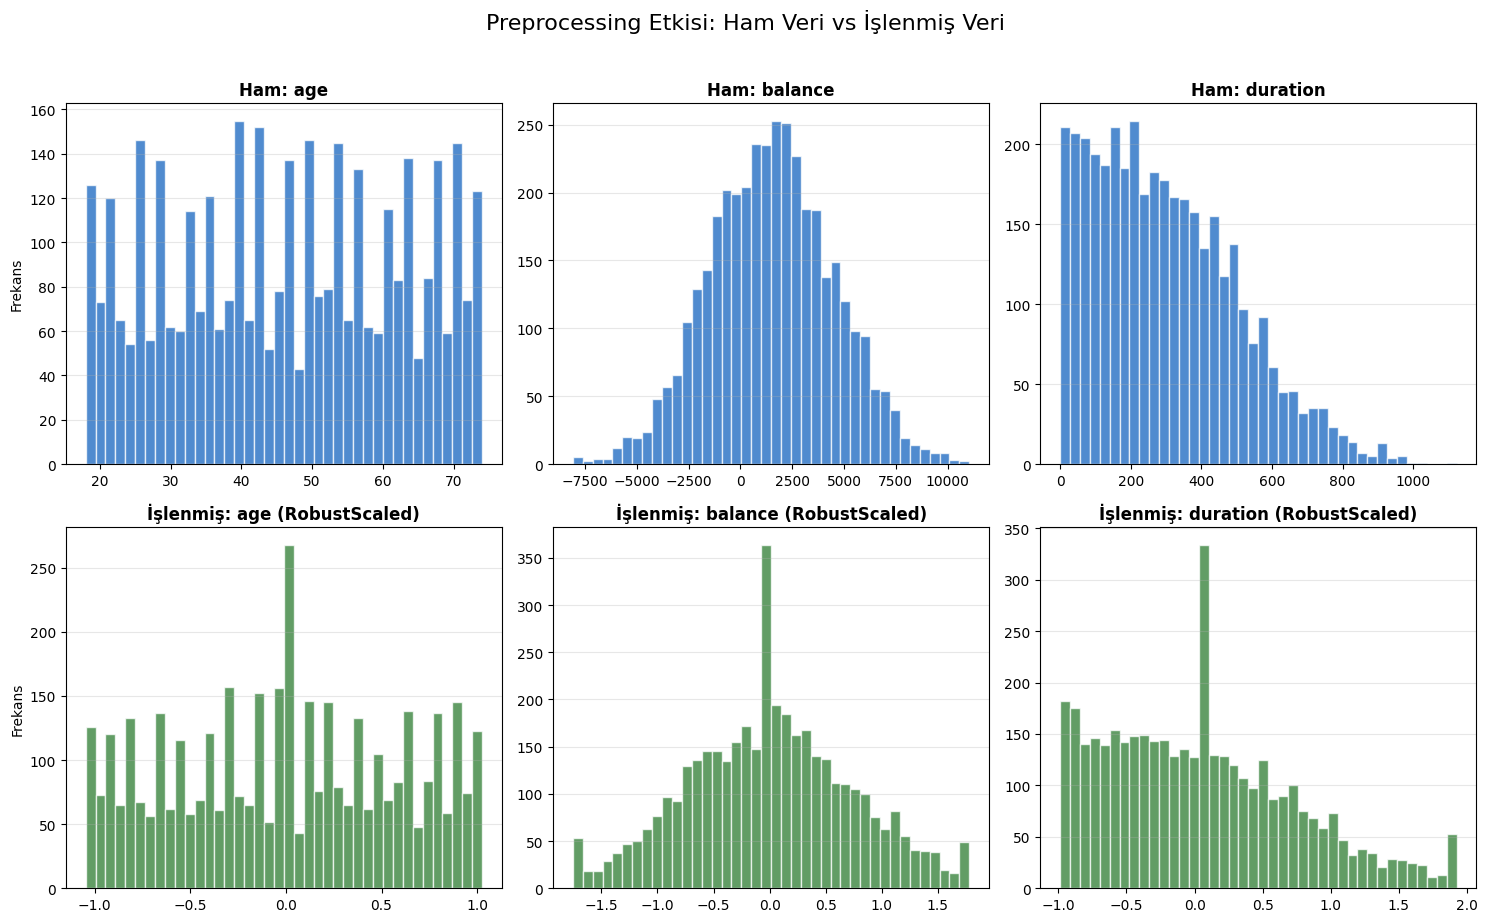

✅ Grafik kaydedildi: 01_preprocessing_effect.png

 ✅ UYGULAMA 1 TAMAMLANDI!
 Çıktılar: full_pipeline nesne, 01_preprocessing_effect.png


In [14]:
# ─────────────────────────────────────────────────────────────
# 9. GÖRSELLEŞTİRME: Preprocessing Etkisi
# ─────────────────────────────────────────────────────────────
print("\n📊 Preprocessing etkisi görselleştiriliyor...")

fig, axes = plt.subplots(2, 3, figsize=(15, 9))
fig.suptitle("Preprocessing Etkisi: Ham Veri vs İşlenmiş Veri", fontsize=16, y=1.02)

cols_to_plot = ["age", "balance", "duration"]
X_train_transformed_num = (
    full_pipeline.named_steps["preprocessor"]
    .transformers_[0][1]
    .transform(X_train[available_num])
)

for i, col in enumerate(cols_to_plot):
    col_idx = available_num.index(col)
    col_data_raw = X_train[col].dropna()
    col_data_proc = X_train_transformed_num[:, col_idx]

    # Ham
    axes[0, i].hist(col_data_raw, bins=40, color="#1565C0", alpha=0.75, edgecolor="white")
    axes[0, i].set_title(f"Ham: {col}", fontweight="bold")
    axes[0, i].set_ylabel("Frekans" if i == 0 else "")
    axes[0, i].grid(axis="y", alpha=0.3)

    # İşlenmiş
    axes[1, i].hist(col_data_proc, bins=40, color="#2E7D32", alpha=0.75, edgecolor="white")
    axes[1, i].set_title(f"İşlenmiş: {col} (RobustScaled)", fontweight="bold")
    axes[1, i].set_ylabel("Frekans" if i == 0 else "")
    axes[1, i].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("01_preprocessing_effect.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Grafik kaydedildi: 01_preprocessing_effect.png")
plt.close()

print("\n" + "=" * 65)
print(" ✅ UYGULAMA 1 TAMAMLANDI!")
print(" Çıktılar: full_pipeline nesne, 01_preprocessing_effect.png")
print("=" * 65)
